# In-Class Activity: Linear Algebra in Machine Learning
## Regression Models Through Matrix Operations

---

Good morning! 

### **Group Members' Names:**

Group 1 :)
* Anne Jansen
* Maddy Nomer
* Linn Wang
* Derek Goderis
* Brandon Webster


### Overview
This in-class activity explores the connection between linear algebra and regression through hands-on implementation of regression models. You'll work in groups to understand different approaches to the same prediction task.

### Group Assignments
- **Even-numbered Groups (2, 4, ...)**: Hypersurface Model Implementation
- **Odd-numbered Groups (1, 3, ...)**: Radial Basis Function Neural Network

### Activity Structure
1. **Orientation**: Read, explore and setup data (10 minutes)
2. **Main Implementation**: Model Development (50 minutes)
3. **Peer Teaching**: Cross-group Presentations (20  minutes: 2 $\times$ 10)

### Presentation Pairings

Follow this pattern:

| Group Pairs | Models Compared |
|------------|-----------------|
| Groups 1 & 2 | RBF ↔ Hypersurface |
| Groups 3 & 4 | RBF ↔ Hypersurface |
| Groups 5 & 6 | RBF ↔ Hypersurface |

### Learning Objectives
By the end of this activity, you will be able to:
- Apply linear algebra concepts to regression problems
- Compare different approaches to function approximation
- Communicate technical concepts effectively

---
*Note: Please make sure you know your group number and corresponding model assignment before proceeding.*

____

### Read data and form $X$ and $y$

Read in the sklearn diabetes dataset and separate it into two parts: the data matrix $X$ and the targets $y$. In your data matrix $X$ put only two columns `age` and `bmi`. Here is some helper code to get your started and so that you can visualize the target variable $y$. 


Detailed Statistics:
Number of patients: 442
Mean: 152.1
Median: 140.5
Standard deviation: 77.0

Severity Distribution:
Low: 147 patients (33.3%)
Moderate: 130 patients (29.4%)
High: 100 patients (22.6%)
Very High: 64 patients (14.5%)


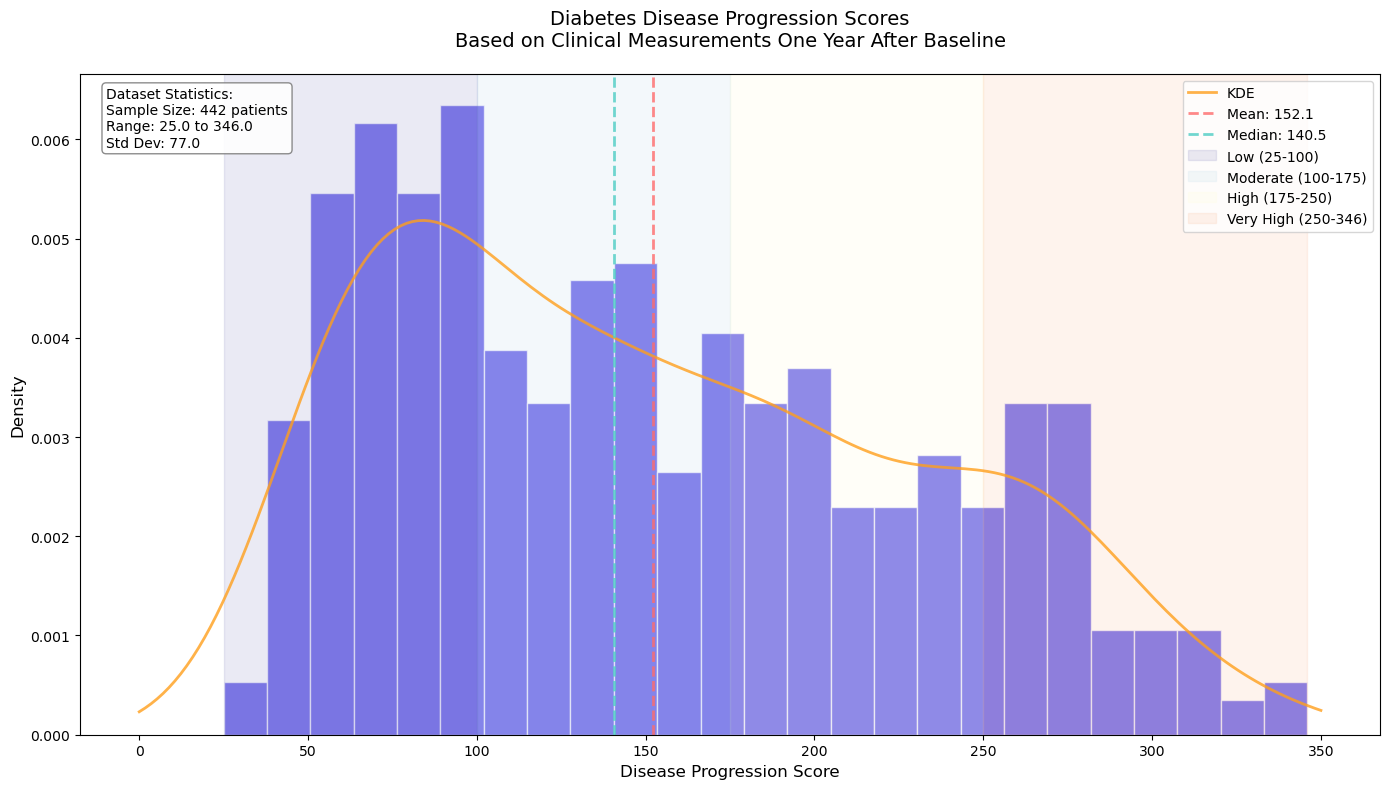

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from scipy import stats
from sklearn.datasets import load_diabetes
from sklearn.preprocessing import StandardScaler

# load data
diabetes = load_diabetes()
y = diabetes.target

X_full = diabetes.data

# use just two features for visualization; you can experiment with different feature pairs
X = X_full[:, [0, 2]]  # age and bmi
feature_names = ['Age', 'BMI']

# calculate some statistics
mean_val = np.mean(y)
median_val = np.median(y)

# create figure with more space for annotations
plt.figure(figsize=(14, 8))

# custom color scheme
main_color = '#4F46E5'  # Main histogram color
highlight_colors = ['#FF6B6B', '#4ECDC4']  # For mean and median

# create histogram with density for better score interpretation
n, bins, patches = plt.hist(y, bins=25, color=main_color, alpha=0.7, 
                          edgecolor='white', density=True)

# kernel density estimate (KDE)
density = stats.gaussian_kde(y)
y_range = np.linspace(0, 350, 200)
plt.plot(y_range, density(y_range), color='#FF9F1C', linewidth=2, 
         label='KDE', alpha=0.8)

# vertical lines for mean and median
plt.axvline(x=mean_val, color=highlight_colors[0], linestyle='--', 
            alpha=0.8, label=f'Mean: {mean_val:.1f}', linewidth=2)
plt.axvline(x=median_val, color=highlight_colors[1], linestyle='--', 
            alpha=0.8, label=f'Median: {median_val:.1f}', linewidth=2)


plt.title('Diabetes Disease Progression Scores\nBased on Clinical Measurements One Year After Baseline', 
          fontsize=14, pad=20)
plt.xlabel('Disease Progression Score', fontsize=12)
plt.ylabel('Density', fontsize=12)

# severity score bands
severity_ranges = [
    (25, 100, 'Low'),
    (100, 175, 'Moderate'),
    (175, 250, 'High'),
    (250, 346, 'Very High')
]

# colored bands for severity ranges
for i, (start, end, label) in enumerate(severity_ranges):
    plt.axvspan(start, end, alpha=0.1, 
                color=plt.cm.RdYlBu_r(i/len(severity_ranges)),
                label=f'{label} ({start}-{end})')

# text box with statistics
stats_text = (
    f'Dataset Statistics:\n'
    f'Sample Size: {len(y):,} patients\n'
    f'Range: {y.min():.1f} to {y.max():.1f}\n'
    f'Std Dev: {np.std(y):.1f}'
)
plt.text(0.02, 0.98, stats_text,
         transform=plt.gca().transAxes,
         verticalalignment='top',
         bbox=dict(boxstyle='round', facecolor='white', 
                  alpha=0.9, edgecolor='gray'),
         fontsize=10)


plt.legend(loc='upper right', fontsize=10)

plt.tight_layout()

# additional insights
print("\nDetailed Statistics:")
print(f"Number of patients: {len(y):,}")
print(f"Mean: {mean_val:.1f}")
print(f"Median: {median_val:.1f}")
print(f"Standard deviation: {np.std(y):.1f}")
print("\nSeverity Distribution:")
for start, end, label in severity_ranges:
    count = np.sum((y >= start) & (y < end))
    percentage = (count/len(y))*100
    print(f"{label}: {count:,} patients ({percentage:.1f}%)")

Since you have this plot in front of you, discuss it within your group. What does it tell you? Let's suppose we can take this dataset at face value: this is an accurate reading of random people in the population with no biases. Look at the median and the mode: the "average" person in the population is at Moderate risk of diabetes! And, nearly half (portion to the right of the cyan median line) are on the high side of Moderate or in the High or Very High bands. 

Thoughts? 

* The plot shows a general distribution of disease progression as well as the average using both mean and median values. It also shows binning through the background colors to add categories to the scoring and provide context in terms of "good" vs "bad" scores. The distribution is skewed, so more people are on the lower ends of low/moderate disease progression, but there is still an alarming amount of the population in the high/very high categories as mentioned above.

____


## Mathematical Formulation of Regression Models

### Choose Your Model Based on Group Number
**Important**: Follow only the section corresponding to your group number (Even: Hypersurface, Odd: RBF-NN)

---

### <font color="#118844">Even Groups: Hypersurface Model</font>
#### Model Equation

Your model is given by:

$$y = w_0 + w_1x_1 + w_2x_2$$

Congrats - your group got the better of the two models! What is different from the models we have seen so far in this course is that this has three unknowns $w_0, w_1, w_2$. If we did this "by hand", we would have three equations in three unknowns, which, while possible, would be very tedious. In general, we would have many more than three parameters; here, I chose three so that we can still visualize what we are doing. 

How can we find the three parameters using linear algebra? 

#### Your Task: Convert to Matrix Form

On your whiteboard, show how this equation becomes a matrix problem by:

1. Writing out the equation for several data points:
   $$y_1 = w_0 + w_1x_{11} + w_2x_{12}$$
   $$y_2 = w_0 + w_1x_{21} + w_2x_{22}$$
   $$y_3 = w_0 + w_1x_{31} + w_2x_{32}$$
   $$\vdots$$

2. Converting to matrix form:
   $$\begin{bmatrix} y_1 \\ y_2 \\ y_3 \\ \vdots \end{bmatrix} = \begin{bmatrix} 1 & x_{11} & x_{12} \\ 1 & x_{21} & x_{22} \\ 1 & x_{31} & x_{32} \\ \vdots & \vdots & \vdots \end{bmatrix} \begin{bmatrix} w_0 \\ w_1 \\ w_2 \end{bmatrix}$$

Where do the $y$ values come from? Where will you get the $x_{ij}$? State this clearly below. What is $y$ here?

3. Writing in compact notation:
   $$\mathbf{y} = \mathbf{X}\mathbf{w}$$

Under what conditions can you invert $\mathbf{X}$ to directly solve for $\mathbf{w}$? That is, can we use $\mathbf{w} = \mathbf{X}^{-1}\mathbf{y} $?  

4. Use these equations:
   $$\mathbf{X}^T\mathbf{y} = \mathbf{X}^T\mathbf{X}\mathbf{w}$$
   $$\mathbf{w} = (\mathbf{X}^T\mathbf{X})^{-1}\mathbf{X}^T\mathbf{y}$$

Construct your $y$ and your $X$ from the dataset above. Code the Normal Equation using only basic `linalg` operations. That is, don't cheat and use `.solve`! Only use what you see in the equation: transpose, inverse and multiplication. Show the values of $\mathbf{w}$ you get. Make a plot of your prediction with your predicted $y$ as a colormap in a 2D plane with the two features in $X$ as the axes. Plot the dataset on this colormap. 

As you work, create a $5 - 10$ minute lecture for your pair group so that you can teach them everything you learned. Even if you don't finish, start your lecture at 9:30 - it is more important that you have a discussion than complete this perfectly. Take a picture of your lecture and submit that. 

---

### <font color="#118844">Odd Groups: RBF Neural Network</font> US :)
#### Model Equation

Your model is given by:

$$y = \sum_{d=1}^D a_d \exp\left(-\gamma\|{\mathbf{x}-\mathbf{x}_d}\|^2\right)$$
where:
- $a_d$ are the weights to be learned
- $\gamma$ is a parameter controlling the width of the Gaussians
- $\mathbf{x}_d$ are the centers of the Gaussian basis functions

Congrats - your group got the better of the two models! 


#### Your Task: Convert to Matrix Form


On your whiteboard, show how this equation becomes a matrix problem by:

1. Writing out the equation for several data points:
   $$y_1 = a_1G_1(\mathbf{x}_1) + a_2G_2(\mathbf{x}_1) + \cdots + a_DG_D(\mathbf{x}_1)$$
   $$y_2 = a_1G_1(\mathbf{x}_2) + a_2G_2(\mathbf{x}_2) + \cdots + a_DG_D(\mathbf{x}_2)$$
   $$y_3 = a_1G_1(\mathbf{x}_3) + a_2G_2(\mathbf{x}_3) + \cdots + a_DG_D(\mathbf{x}_3)$$
   $$\vdots$$

   where $G_d(\mathbf{x}_i) = \exp(-\gamma\|{\mathbf{x}_i-\mathbf{x}_d}\|^2)$

Pay very close attention to this notation. You might want to draw a picture on your whiteboard to explain where the terms like $G_1(\mathbf{x}_1)$ come from. 


2. Converting to matrix form:
   $$\begin{bmatrix} y_1 \\ y_2 \\ y_3 \\ \vdots \end{bmatrix} = \begin{bmatrix} G_1(\mathbf{x}_1) & G_2(\mathbf{x}_1) & \cdots & G_D(\mathbf{x}_1) \\ G_1(\mathbf{x}_2) & G_2(\mathbf{x}_2) & \cdots & G_D(\mathbf{x}_2) \\ G_1(\mathbf{x}_3) & G_2(\mathbf{x}_3) & \cdots & G_D(\mathbf{x}_3) \\ \vdots & \vdots & \ddots & \vdots \end{bmatrix} \begin{bmatrix} a_1 \\ a_2 \\ a_3 \\ \vdots \end{bmatrix}$$

What's going on here? What is $a_d$, again? What sort of flow do you see here--does $G_D$ give information to $a_d$? 

Write the code to construct these matrices. You can do this however you wish, but I often use list comprehensions to easily fill $n$-dimensional arrays with a known functional dependence.

Note that this model has an interesting aspect to it: the $x_d$ are the locations of the datapoints. If you use all of them, you will have a square matrix. This is called "interpolation", and the model $y$ will give predictions everywhere but go through the datapoints. What if you only use _some_ of the data? For example, sample $10$ points from the data and use that: you can simply slice $N$ rows from the data matrix. 

How will you choose $\gamma$? What is $\gamma$, anyway?  

If you get stuck on any of this, feel free to talk to other groups doing the RBF-NN model. 



3. Writing in compact notation:
   $$\mathbf{y} = \mathbf{G}\mathbf{a}$$

4. Use these equations:
   $$\mathbf{G}^T\mathbf{y} = \mathbf{G}^T\mathbf{G}\mathbf{a}$$
   $$\mathbf{a} = (\mathbf{G}^T\mathbf{G})^{-1}\mathbf{G}^T\mathbf{y}$$

Code the Normal Equation using only basic `linalg` operations. That is, don't cheat and use `.solve`! Only use what you see in the equation: transpose, inverse and multiplication. Show the values of $\mathbf{w}$ you get. Make a plot of your prediction with your predicted $y$ as a colormap in a 2D plane with the two features in $X$ as the axes. Plot the dataset on this colormap. 

Be ready to present at 9:30. 


In [13]:
# x_ex = np.array([1, 2, 3, 4])
# y_ex = np.array([2, 1, 0, 0]).T

# gamma = .005 #?
# G = np.zeros((4, 4))

# for i in range(4):
#     for j in range(4):
#         G[i, j] = np.exp(-gamma*(x_ex[i]*x_ex[j])**2)
        
# print(G)

# # y = Ga
# a = np.linalg.inv(G.T@G)@G.T@y_ex
# print(a)

# y_pred = G@a

# plt.scatter(y_ex, y_pred)

In [14]:
# # x = np.array([1, 2, 3, 4])
# # y = np.array([2, 1, 0, 0]).T

# gamma = 2 #?
# G = np.zeros((len(X), len(X)))

# for i in range(len(X)):
#     for j in range(len(X)):
#         G[i, j] = np.exp(-gamma*((X[i, 0]*X[j, 0])**2 + (X[i, 1]*X[j, 1])**2))

# print(G)

# # y = Ga
# a = np.linalg.inv(G.T@G)@G.T@y
# print(a)

# y_pred = G@a

# print(y-y_pred)



# age_range = np.linspace(X[:, 0].min(), X[:, 0].max(), 100)
# bmi_range = np.linspace(X[:, 1].min(), X[:, 1].max(), 100)
# age_grid, bmi_grid = np.meshgrid(age_range, bmi_range)

# # Flatten the grid for applying the RBF
# grid_points = np.c_[age_grid.ravel(), bmi_grid.ravel()]

# plt.figure(figsize=(10, 8))
# plt.contourf(age_grid, bmi_grid, y_pred, cmap='viridis', alpha=0.7)
# plt.colorbar(label="Predicted Value")

# # Scatter plot of the original dataset
# plt.scatter(X[:, 0], X[:, 1], c=y, cmap='cool', edgecolor='k', s=50)
# plt.xlabel("Age")
# plt.ylabel("BMI")
# plt.title("Prediction Colormap with Data Overlay")
# plt.show()

Computed weights (a): [ 4450109.14009422 -4285136.90790368  9970187.36449364   668664.40996194
 -4937886.52123054  5805885.8750237   -285099.67542154 -1084307.30771963
  4921343.74686564 -5389956.27273716 15330937.5752563  -2038746.55362857
 -5155043.48820001 -4551872.68397183 -4659698.69355347 -2038700.56522892
 -3136741.14377665  1620366.15394348 -3778837.11332183 -3893401.81287945
  1196667.8618092   1814281.42883268  -721004.27770608  5434400.31598275
 -5237107.98461069]


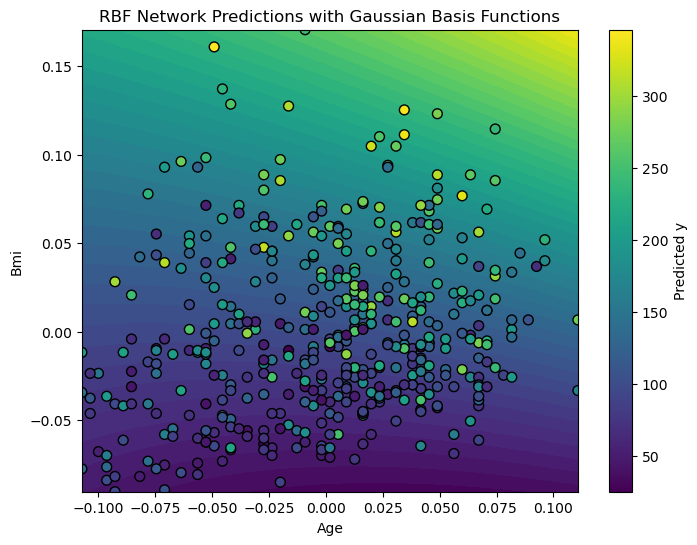

In [23]:
gamma = 0.05
N = len(X)
D = 25

X_centers = X[:D]  

G = np.zeros((N, D))
for i in range(N):
    for j in range(D):
        G[i, j] = np.exp(-gamma * np.linalg.norm(X[i] - X_centers[j])**2)

G_T = G.T
GT_G = np.dot(G_T, G)
GT_y = np.dot(G_T, y[:N])  
GT_G_inv = np.linalg.pinv(GT_G)

a = np.dot(GT_G_inv, GT_y)
print("Computed weights (a):", a)

x_grid, y_grid = np.meshgrid(np.linspace(X[:, 0].min(), X[:, 0].max(), 50),
                             np.linspace(X[:, 1].min(), X[:, 1].max(), 50))
predictions = np.zeros(x_grid.shape)

for i in range(x_grid.shape[0]):
    for j in range(x_grid.shape[1]):
        x_point = np.array([x_grid[i, j], y_grid[i, j]])
        G_point = np.array([np.exp(-gamma * np.linalg.norm(x_point - center)**2) for center in X_centers])
        predictions[i, j] = np.dot(G_point, a)

plt.figure(figsize=(8, 6))
plt.contourf(x_grid, y_grid, predictions, levels=50, cmap='viridis')
plt.scatter(X[:N, 0], X[:N, 1], c=y[:N], edgecolor='k', s=50, cmap='viridis')
plt.colorbar(label='Predicted y')
plt.xlabel(feature_names[0].capitalize())
plt.ylabel(feature_names[1].capitalize())
plt.title("RBF Network Predictions with Gaussian Basis Functions")
plt.show()

---

#### Key Points to Notice
1. Both models ultimately become $\mathbf{A}\mathbf{x} = \mathbf{b}$ problems
2. Both use the same form of normal equations
3. The main difference is in how we construct the matrix ($\mathbf{X}$ or $\mathbf{G}$)
4. The dimensions and interpretation of the weight vectors ($\mathbf{w}$ or $\mathbf{a}$) differ


Add your group member names to the submission description in D2L.

